In [1]:
library(SNFtool)
library(ggplot2)
library(dplyr)
library(tidyr)
library(mclust)       # adjustedRandIndex
library(png)
library(grid)
library(ggpubr)
library(aricode)      # NMI, VI
library(cluster)      # silhouette
library(igraph)
library(clusterCrit)  # CH, DBI, Dunn (intCriteria)

Warning message:
“package ‘SNFtool’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘mclust’ was built under R version 4.3.3”
Package 'mclust' version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.


Attaching package: ‘igraph’


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Warning message:
“package ‘clusterCrit’ was built under R version 4.3.3”


In [4]:
setwd('/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/Review/Autoencoder')
mrna_mci <- read.csv("/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/THE_github/extdata/all_mci_mrna.csv", header=TRUE, row.names=1)
#mrna_mci = read.csv('/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/Review/Autoencoder/mrna_mci172_withlab.csv', header=TRUE, row.names=1)
metab_mci <- read.csv("/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/THE_github/extdata/all_mci_metab.csv", header=TRUE, row.names=1)

In [5]:
table(mrna_mci$Label)


EMCI LMCI 
 201  200 

In [2]:
library(SNFtool)
library(mclust)  # for adjustedRandIndex

run_snf_for_mci <- function(mrna_mci, metab_mci,
                            K_e = 10, alpha_e = 0.8, T_e = 10,
                            K_l = 10, alpha_l = 0.8, T_l = 20) {
  # EMCI
  metab_emci <- metab_mci[metab_mci$Label == "EMCI", ]
  mrna_emci  <- mrna_mci[mrna_mci$Label  == "EMCI", ]
  metab_emci <- metab_emci[, -1, drop = FALSE]  # remove Label
  mrna_emci  <- mrna_emci[,  -1, drop = FALSE]

  # LMCI
  metab_lmci <- metab_mci[metab_mci$Label == "LMCI", ]
  mrna_lmci  <- mrna_mci[mrna_mci$Label  == "LMCI", ]
  metab_lmci <- metab_lmci[, -1, drop = FALSE]
  mrna_lmci  <- mrna_lmci[,  -1, drop = FALSE]

  ## Distance matrices
  Dist1_e <- (dist2(as.matrix(mrna_emci),  as.matrix(mrna_emci)))^(1/2)
  Dist2_e <- (dist2(as.matrix(metab_emci), as.matrix(metab_emci)))^(1/2)

  Dist1_l <- (dist2(as.matrix(mrna_lmci),  as.matrix(mrna_lmci)))^(1/2)
  Dist2_l <- (dist2(as.matrix(metab_lmci), as.matrix(metab_lmci)))^(1/2)

  ## Affinity + SNF
  W1_e <- affinityMatrix(Dist1_e, K_e, alpha_e)
  W2_e <- affinityMatrix(Dist2_e, K_e, alpha_e)
  W_e  <- SNF(list(W1_e, W2_e), K_e, T_e)

  W1_l <- affinityMatrix(Dist1_l, K_l, alpha_l)
  W2_l <- affinityMatrix(Dist2_l, K_l, alpha_l)
  W_l  <- SNF(list(W1_l, W2_l), K_l, T_l)

  ## Clustering
  C <- 2
  group_e <- spectralClustering(W_e, C)
  group_l <- spectralClustering(W_l, C)

  list(
    W_e     = W_e,
    W_l     = W_l,
    group_e = group_e,
    group_l = group_l
  )
}


In [7]:
setwd('/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/Review/Autoencoder')

metab_mci <- read.csv(
  "/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/THE_github/extdata/all_mci_metab.csv",
  header = TRUE, row.names = 1
)

bottlenecks <- c(50, 172, 512, 1024, 5000, 10000, 20032)

results_e <- list()
results_l <- list()
snf_results <- list()  

for (b in bottlenecks) {
  cat("Running SNF for bottleneck =", b, "\n")
  
  mrna_file <- sprintf("mrna_mci%d_withlab.csv", b)  # adjust pattern if needed
  mrna_mci  <- read.csv(mrna_file, header = TRUE, row.names = 1)
  
  res <- run_snf_for_mci(mrna_mci, metab_mci)
  
  results_e[[as.character(b)]] <- res$group_e
  results_l[[as.character(b)]] <- res$group_l
  snf_results[[as.character(b)]] <- res
}

save(results_e,
     results_l,
     snf_results,
     file = "/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/Review/Autoencoder/SNF_results_allnew.RData")


Running SNF for bottleneck = 50 
Running SNF for bottleneck = 172 
Running SNF for bottleneck = 512 
Running SNF for bottleneck = 1024 
Running SNF for bottleneck = 5000 
Running SNF for bottleneck = 10000 
Running SNF for bottleneck = 20032 


In [8]:
setwd('/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/Review/Autoencoder')

metab_mci <- read.csv(
  "/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/THE_github/extdata/all_mci_metab.csv",
  header = TRUE, row.names = 1
)

bottlenecks <- c(50, 172, 512, 1024, 5000, 10000, 20032)

results_e <- list()
results_l <- list()
snf_results <- list()  

for (b in bottlenecks) {
  cat("Running SNF for bottleneck =", b, "\n")

  # choose mrna file based on dimension
  if (b == 172) {
    mrna_file <- "/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/THE_github/extdata/all_mci_mrna.csv"
  } else if (b == 20032) {
    mrna_file <- "/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/Review/Autoencoder/mrna_mci20032_ori_withlab.csv"
  } else {
    mrna_file <- sprintf("mrna_mci%d_withlab.csv", b)  # default pattern
  }

  mrna_mci <- read.csv(mrna_file, header = TRUE, row.names = 1)

  res <- run_snf_for_mci(mrna_mci, metab_mci)

  results_e[[as.character(b)]] <- res$group_e
  results_l[[as.character(b)]] <- res$group_l
  snf_results[[as.character(b)]] <- res
}

save(results_e,
     results_l,
     snf_results,
     file = "/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/Review/Autoencoder/SNF_results_old172ori.RData")

Running SNF for bottleneck = 50 
Running SNF for bottleneck = 172 
Running SNF for bottleneck = 512 
Running SNF for bottleneck = 1024 
Running SNF for bottleneck = 5000 
Running SNF for bottleneck = 10000 
Running SNF for bottleneck = 20032 


In [73]:
library(SNFtool)
library(png)
library(grid)
library(ggpubr)

outdir <- "SNF_heatmaps_png"
dir.create(outdir, showWarnings = FALSE)

combined_plots <- list()

plot_snf_heatmap <- function(W, group, labels, outfile) {
  png(outfile, width = 1200, height = 1200, res = 300)
  displayClustersWithHeatmap(W, group, labels)
  dev.off()
}

for (b in bottlenecks) {
  cat("Combining heatmaps for dim =", b, "\n")
  
  res <- snf_results[[as.character(b)]]
  
  W_e     <- res$W_e
  W_l     <- res$W_l
  group_e <- res$group_e
  group_l <- res$group_l
  
  ## Label tracks for EMCI
  truelabel_e <- rep(1, length(group_e))
  M_label_e <- cbind(group_e, truelabel_e)
  colnames(M_label_e) <- c("spectralClustering","TrueLabel")
  M_label_colors_e <- cbind(
    spectralClustering = getColorsForGroups(M_label_e[,"spectralClustering"], 
                                            colors=c("deepskyblue1","seagreen2")),
    TrueLabel = getColorsForGroups(M_label_e[,"TrueLabel"], 
                                   colors=c("navy","red1"))
  )
  
  ## Label tracks for LMCI
  truelabel_l <- rep(1, length(group_l))
  M_label_l <- cbind(group_l, truelabel_l)
  colnames(M_label_l) <- c("spectralClustering","TrueLabel")
  M_label_colors_l <- cbind(
    spectralClustering = getColorsForGroups(M_label_l[,"spectralClustering"], 
                                            colors=c("orchid","gold")),
    TrueLabel = getColorsForGroups(M_label_l[,"TrueLabel"], 
                                   colors=c("navy","red1"))
  )
  
  ## ---- Save heatmaps ----
  file_e <- file.path(outdir, paste0("EMCI_dim", b, ".png"))
  file_l <- file.path(outdir, paste0("LMCI_dim", b, ".png"))
  
  plot_snf_heatmap(W_e, group_e, M_label_colors_e, file_e)
  plot_snf_heatmap(W_l, group_l, M_label_colors_l, file_l)
  
  ## ---- Load images as grobs ----
  img_e <- rasterGrob(readPNG(file_e), interpolate = TRUE)
  img_l <- rasterGrob(readPNG(file_l), interpolate = TRUE)
  
  ## ---- Combine with ggpubr ----
  combined <- ggarrange(
    ggplot() + annotation_custom(img_e) + theme_void(),
    ggplot() + annotation_custom(img_l) + theme_void(),
    ncol = 2,
    labels = c("EMCI", "LMCI"),
    font.label = list(size = 12, face = "bold")
  )
  
  combined_plots[[as.character(b)]] <- combined
  
  ## Save combined figure
  ggsave(
    file.path(outdir, paste0("Combined_dim", b, ".png")),
    combined,
    width = 12,
    height = 6
  )
}


Combining heatmaps for dim = 50 
Combining heatmaps for dim = 172 
Combining heatmaps for dim = 512 
Combining heatmaps for dim = 1024 
Combining heatmaps for dim = 5000 
Combining heatmaps for dim = 10000 
Combining heatmaps for dim = 20032 


In [5]:
bottlenecks <- c(50, 172, 512, 1024, 5000, 10000, 20032)
input = '_allnew'
#input = '_old172ori'
load(paste0("/nfs/turbo/umms-lgarmire/home/yhdu/Bowei_NAS/EFIGA/Review/Autoencoder/SNF_results",input,".RData"),verbose=TRUE)

Loading objects:
  results_e
  results_l
  snf_results


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


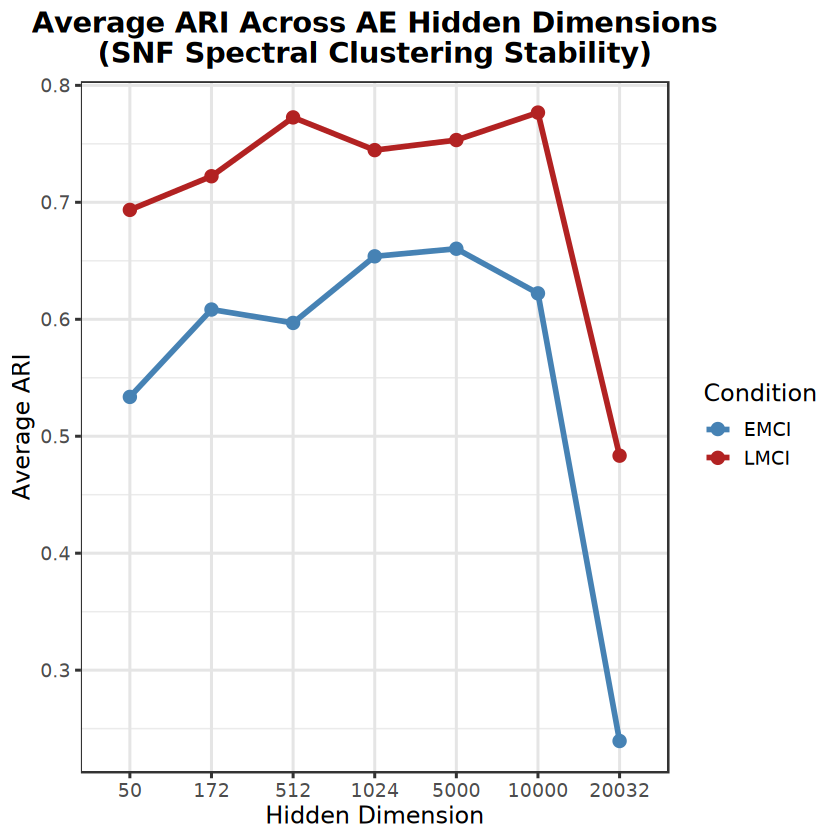

In [6]:
dims <- as.character(bottlenecks)
n <- length(dims)

ARI_e <- matrix(NA, n, n, dimnames = list(dims, dims))
ARI_l <- matrix(NA, n, n, dimnames = list(dims, dims))

for (i in 1:n) {
  for (j in i:n) {
    g1_e <- results_e[[dims[i]]]
    g2_e <- results_e[[dims[j]]]
    ARI_e[i, j] <- ARI_e[j, i] <- adjustedRandIndex(g1_e, g2_e)
    
    g1_l <- results_l[[dims[i]]]
    g2_l <- results_l[[dims[j]]]
    ARI_l[i, j] <- ARI_l[j, i] <- adjustedRandIndex(g1_l, g2_l)
  }
}
# Compute column means
mean_e <- colMeans(ARI_e)
mean_l <- colMeans(ARI_l)

# Put in a tidy data frame
df_plot <- data.frame(
  Dim = factor(bottlenecks, levels = bottlenecks),  # Make x-axis discrete!
  EMCI = mean_e,
  LMCI = mean_l
) %>%
  pivot_longer(cols = c("EMCI", "LMCI"),
               names_to = "Condition",
               values_to = "MeanARI")

# line plot
plot_ari = ggplot(df_plot, aes(x = Dim, y = MeanARI, color = Condition, group = Condition)) +
  geom_line(size = 1.2) +
  geom_point(size = 3) +
  scale_color_manual(values = c("EMCI" = "steelblue", "LMCI" = "firebrick")) +
  labs(
    x = "Hidden Dimension",
    y = "Average ARI",
    title = "Average ARI Across AE Hidden Dimensions\n(SNF Spectral Clustering Stability)"
  ) +
  theme_bw(base_size = 14) +
  theme(
    panel.grid.major = element_line(color = "grey90"),
    plot.title = element_text(face = "bold", hjust = 0.5)
  )
plot_ari

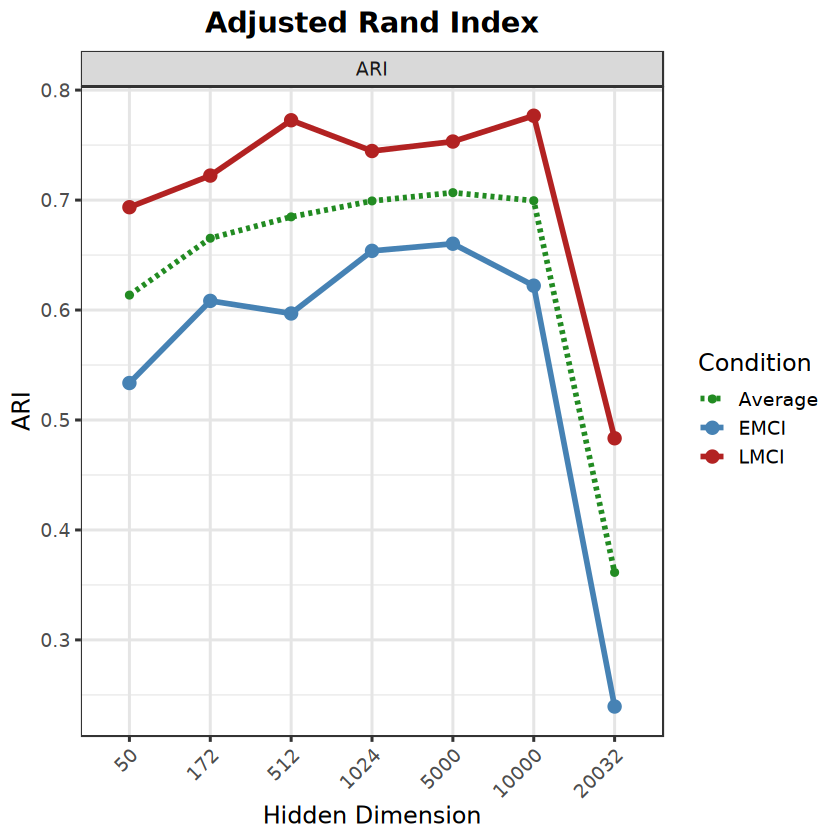

In [44]:
library(dplyr)
library(ggplot2)

# 1) Create Average line (across EMCI + LMCI for each Dim)
df_ari_mean <- df_plot %>%
  group_by(Dim) %>%
  summarise(
    MeanARI = mean(MeanARI, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  mutate(Condition = "Average")

# 2) Bind back to original df_plot
df_ari_all <- bind_rows(
  df_plot,
  df_ari_mean  # now has Condition = "Average"
)

df_ari_all$Method = 'ARI'

# 3) Plot with EMCI, LMCI, and green Average like your other plots
plot_ari <- ggplot(
  df_ari_all,
  aes(x = Dim, y = MeanARI,
      color = Condition,
      linetype = Condition,
      group = Condition)
) +
  geom_line(size = 1.2) +
  geom_point(aes(size = Condition)) +
  scale_color_manual(values = c(
    EMCI = "steelblue",
    LMCI = "firebrick",
    Average = "forestgreen"
  )) +
  scale_linetype_manual(values = c(
    EMCI = "solid",
    LMCI = "solid",
    Average = "dashed"
  )) +
  scale_size_manual(values = c(
    EMCI = 3,
    LMCI = 3,
    Average = 1.5
  )) +
  labs(
    x = "Hidden Dimension",
    y = "ARI",
    #title = "Average ARI Across AE Hidden Dimensions\n(SNF Spectral Clustering Stability)"
    title = "Adjusted Rand Index"
  ) +
  theme_bw(base_size = 14) +
  theme(
    panel.grid.major = element_line(color = "grey90"),
    plot.title = element_text(face = "bold", hjust = 0.5),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )+
  facet_wrap(~ Method, nrow = 1)

plot_ari


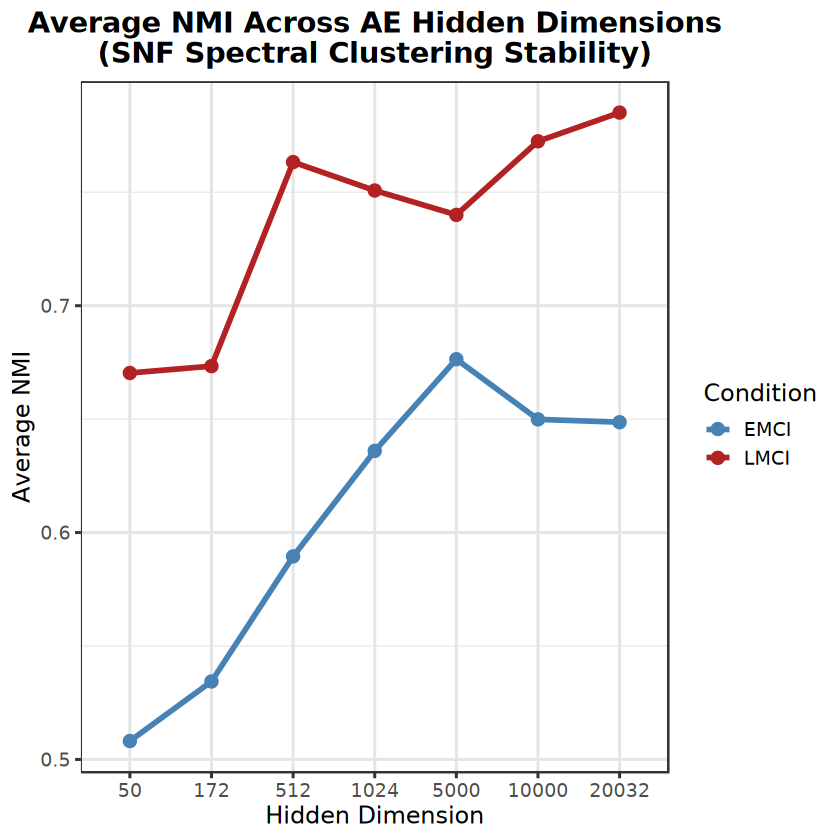

In [88]:
# install.packages("aricode")
library(aricode)

dims <- names(results_e)  # e.g., "50","172","512",...
n <- length(dims)

# EMCI
NMI_e <- matrix(NA, n, n, dimnames = list(dims, dims))
for (i in 1:n) {
  for (j in i:n) {
    g1 <- results_e[[dims[i]]]
    g2 <- results_e[[dims[j]]]
    NMI_e[i, j] <- NMI(g1, g2)
    NMI_e[j, i] <- NMI_e[i, j]
  }
}

# LMCI
NMI_l <- matrix(NA, n, n, dimnames = list(dims, dims))
for (i in 1:n) {
  for (j in i:n) {
    g1 <- results_l[[dims[i]]]
    g2 <- results_l[[dims[j]]]
    NMI_l[i, j] <- NMI(g1, g2)
    NMI_l[j, i] <- NMI_l[i, j]
  }
}

mean_nmi_e <- colMeans(NMI_e)
mean_nmi_l <- colMeans(NMI_l)

df_plot_nmi <- data.frame(
  Dim = factor(dims, levels = dims),   # ensures uneven spacing
  EMCI = mean_nmi_e,
  LMCI = mean_nmi_l
) %>%
  pivot_longer(cols = c("EMCI", "LMCI"),
               names_to = "Condition",
               values_to = "MeanNMI")

ggplot(df_plot_nmi, aes(x = Dim, y = MeanNMI, color = Condition, group = Condition)) +
  geom_line(size = 1.2) +
  geom_point(size = 3) +
  scale_color_manual(values = c("EMCI" = "steelblue", "LMCI" = "firebrick")) +
  labs(
    x = "Hidden Dimension",
    y = "Average NMI",
    title = "Average NMI Across AE Hidden Dimensions\n(SNF Spectral Clustering Stability)"
  ) +
  theme_bw(base_size = 14) +
  theme(
    panel.grid.major = element_line(color = "grey90"),
    plot.title = element_text(face = "bold", hjust = 0.5)
  )


Dim,EMCI,LMCI
<dbl>,<dbl>,<dbl>
50,0.001289891,0.001660351
172,0.001375021,0.001749435
512,0.001285974,0.001780132
1024,0.001312205,0.001872689
5000,0.001309353,0.001796773
10000,0.001363778,0.001837359
20032,0.001339510,0.001842717


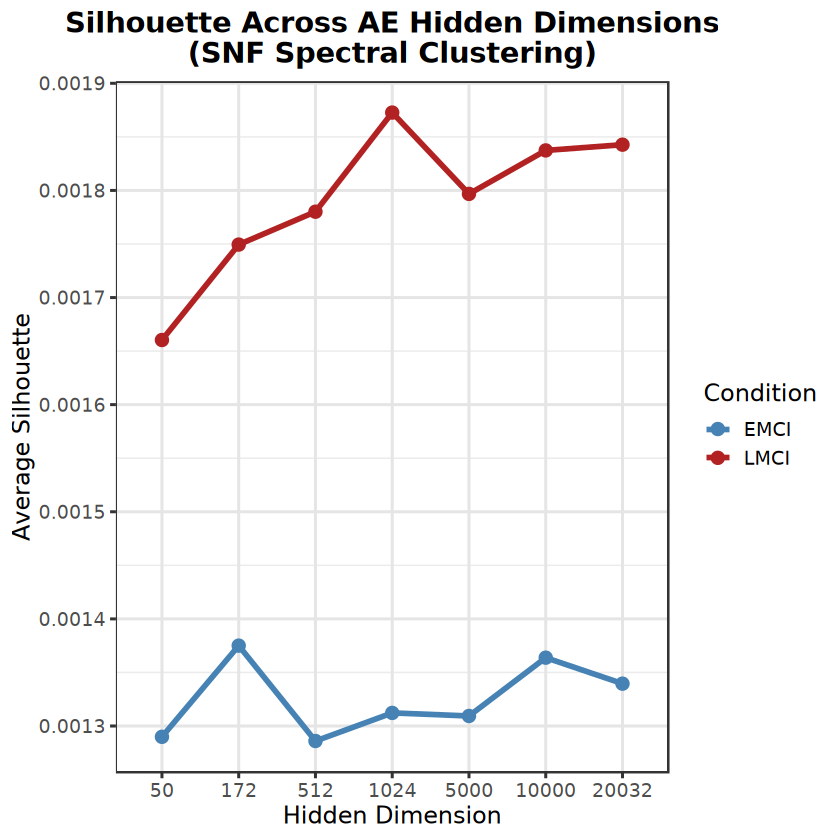

In [89]:
library(cluster)

sil_for_dim <- function(W, group) {
  # turn similarity into distance
  D <- 1 - W
  diag(D) <- 0
  sil <- silhouette(group, as.dist(D))
  mean(sil[, "sil_width"])
}

sil_results <- data.frame(
  Dim = integer(),
  EMCI = numeric(),
  LMCI = numeric()
)

for (b in bottlenecks) {
  res <- snf_results[[as.character(b)]]  # list containing W_e, W_l, group_e, group_l
  sil_e <- sil_for_dim(res$W_e, res$group_e)
  sil_l <- sil_for_dim(res$W_l, res$group_l)
  sil_results <- rbind(sil_results, data.frame(Dim = b, EMCI = sil_e, LMCI = sil_l))
}

sil_results

# Make sure Dim is treated as discrete and in the right order
bottlenecks <- sil_results$Dim

df_sil <- sil_results %>%
  mutate(Dim = factor(Dim, levels = bottlenecks)) %>%
  pivot_longer(cols = c("EMCI", "LMCI"),
               names_to = "Condition",
               values_to = "Silhouette")

ggplot(df_sil, aes(x = Dim, y = Silhouette,
                   color = Condition, group = Condition)) +
  geom_line(size = 1.2) +
  geom_point(size = 3) +
  scale_color_manual(values = c("EMCI" = "steelblue", "LMCI" = "firebrick")) +
  labs(
    x = "Hidden Dimension",
    y = "Average Silhouette",
    title = "Silhouette Across AE Hidden Dimensions\n(SNF Spectral Clustering)"
  ) +
  theme_bw(base_size = 14) +
  theme(
    panel.grid.major = element_line(color = "grey90"),
    plot.title = element_text(face = "bold", hjust = 0.5)
  )

In [90]:
# Compute entropy of a label vector
entropy_vec <- function(labels) {
  tab <- table(labels)
  p <- tab / sum(tab)
  -sum(p * log(p))  # natural log, base cancels in ratios
}

# Conditional entropy H(X | Y)
conditional_entropy <- function(x, y) {
  # x, y: same length label vectors
  joint <- table(x, y)
  n <- sum(joint)
  
  # P(Y=k)
  p_y <- colSums(joint) / n
  
  H_x_given_y <- 0
  for (k in seq_along(p_y)) {
    col_k <- joint[, k]
    n_k <- sum(col_k)
    if (n_k == 0) next
    p_x_given_yk <- col_k / n_k
    H_x_given_yk <- -sum(p_x_given_yk[p_x_given_yk > 0] * log(p_x_given_yk[p_x_given_yk > 0]))
    H_x_given_y <- H_x_given_y + p_y[k] * H_x_given_yk
  }
  H_x_given_y
}

# Manual V-measure
V_measure_manual <- function(x, y) {
  x <- as.vector(x)
  y <- as.vector(y)
  stopifnot(length(x) == length(y))
  
  H_x <- entropy_vec(x)
  H_y <- entropy_vec(y)
  
  # If one labeling has only one class, handle edge case
  if (H_x == 0 && H_y == 0) return(1)  # identical single cluster
  if (H_x == 0 || H_y == 0) return(0)
  
  H_x_given_y <- conditional_entropy(x, y)
  H_y_given_x <- conditional_entropy(y, x)
  
  homogeneity  <- 1 - H_x_given_y / H_x
  completeness <- 1 - H_y_given_x / H_y
  
  if ((homogeneity + completeness) == 0) {
    return(0)
  } else {
    2 * homogeneity * completeness / (homogeneity + completeness)
  }
}

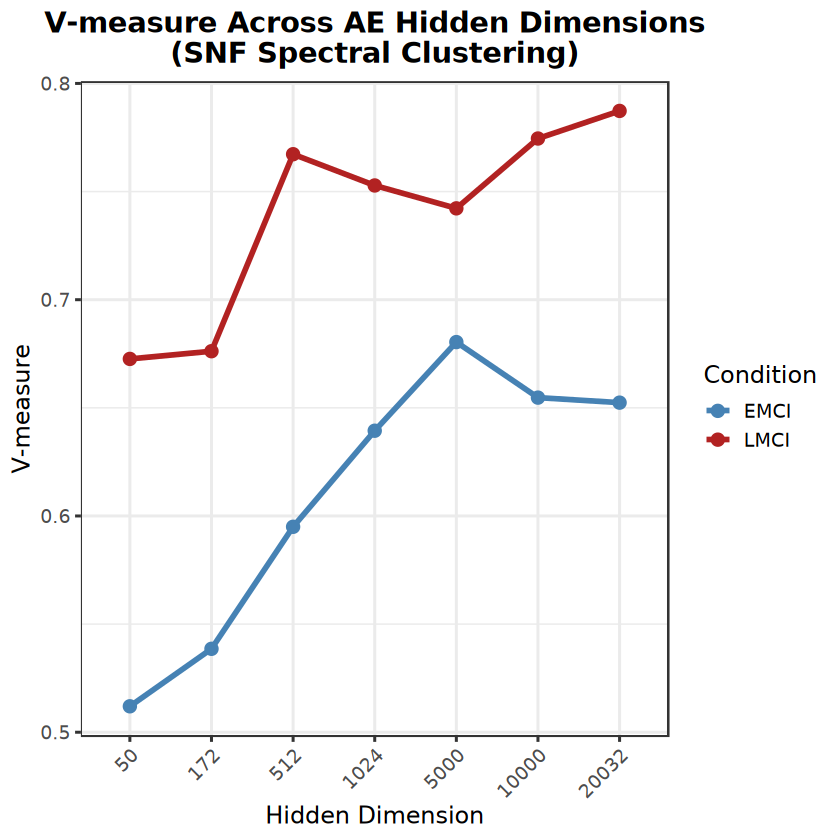

In [91]:
dims_e <- names(results_e)
n_e <- length(dims_e)
V_e <- matrix(NA, n_e, n_e, dimnames = list(dims_e, dims_e))

for (i in 1:n_e) {
  for (j in i:n_e) {
    g1 <- results_e[[dims_e[i]]]
    g2 <- results_e[[dims_e[j]]]
    v  <- V_measure_manual(g1, g2)
    V_e[i, j] <- v
    V_e[j, i] <- v
  }
}

dims_l <- names(results_l)
n_l <- length(dims_l)
V_l <- matrix(NA, n_l, n_l, dimnames = list(dims_l, dims_l))

for (i in 1:n_l) {
  for (j in i:n_l) {
    g1 <- results_l[[dims_l[i]]]
    g2 <- results_l[[dims_l[j]]]
    v  <- V_measure_manual(g1, g2)
    V_l[i, j] <- v
    V_l[j, i] <- v
  }
}

# Convert matrix → vector of means for each dimension
mean_V_e <- colMeans(V_e)
mean_V_l <- colMeans(V_l)

dims <- as.numeric(names(mean_V_e))   # ensure numeric sort
dims <- factor(dims, levels = dims)   # preserve order

df_v <- data.frame(
  Dim = dims,
  EMCI = mean_V_e,
  LMCI = mean_V_l
)

library(tidyr)
library(dplyr)

df_v_long <- df_v %>%
  pivot_longer(cols = c("EMCI", "LMCI"),
               names_to = "Condition",
               values_to = "Vmeasure")

p_v <- ggplot(df_v_long,
              aes(x = Dim, y = Vmeasure, color = Condition, group = Condition)) +
  geom_line(size = 1.2) +
  geom_point(size = 3) +
  scale_color_manual(values = c("EMCI" = "steelblue", "LMCI" = "firebrick")) +
  labs(
    title = "V-measure Across AE Hidden Dimensions\n(SNF Spectral Clustering)",
    x = "Hidden Dimension",
    y = "V-measure"
  ) +
  theme_bw(base_size = 14) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(hjust = 0.5, face = "bold")
  )

p_v

In [7]:
library(SNFtool)
library(igraph)
library(cluster)       # silhouette
library(clusterCrit)   # CH, DBI, Dunn (intCriteria)

In [8]:
# 1) Modularity (higher is better)
modularity_score <- function(W, group) {
  g <- graph_from_adjacency_matrix(W, mode = "undirected", weighted = TRUE, diag = FALSE)
  modularity(g, group)
}

# 2) Conductance (lower is better; here we report weighted average across clusters)
conductance_manual <- function(W, group) {
  g <- graph_from_adjacency_matrix(W, mode = "undirected", weighted = TRUE, diag = FALSE)
  clusters <- unique(group)
  scores <- numeric(length(clusters))
  sizes  <- numeric(length(clusters))
  
  for (i in seq_along(clusters)) {
    S <- which(group == clusters[i])
    
    # volume = sum of degrees inside S
    vol_S <- sum(strength(g, vids = S))
    vol_C <- sum(strength(g, vids = setdiff(V(g), S)))
    
    # cut size = sum of edge weights crossing the boundary
    cut_S <- sum(E(g)[from(S) & to(setdiff(V(g), S))]$weight)
    
    scores[i] <- cut_S / min(vol_S, vol_C)
    sizes[i]  <- length(S)
  }
  
  # weighted average across clusters
  weighted.mean(scores, sizes)
}

conductance_score <- function(W, group) {
  conductance_manual(W, group)
}

# 3–5) CH, DBI, Dunn from clusterCrit
# We approximate feature space using rows of (1 - W) as "features".
int_criteria_scores <- function(W, group) {
  D <- 1 - W
  diag(D) <- 0
  X <- as.matrix(D)                     # objects × features (approximation)
  labs <- as.integer(group)
  crit <- intCriteria(X, labs,
                      c("calinski_harabasz", "davies_bouldin", "dunn"))
  list(
    CH   = crit$calinski_harabasz,
    DBI  = crit$davies_bouldin,
    Dunn = crit$dunn
  )
}

# 6) Eigen-gap for 2 clusters (λ3 - λ2 of normalized Laplacian)
eigengap_score <- function(W) {
  # normalized Laplacian: L = I - D^{-1/2} W D^{-1/2}
  d <- rowSums(W)
  Dinvhalf <- diag(1 / sqrt(d + 1e-12))
  L <- diag(nrow(W)) - Dinvhalf %*% W %*% Dinvhalf
  eigvals <- eigen(L, only.values = TRUE)$values
  eigvals <- sort(Re(eigvals))
  if (length(eigvals) < 3) return(NA_real_)
  eigvals[3] - eigvals[2]
}

# 7) Silhouette (average)
silhouette_score <- function(W, group) {
  D <- 1 - W
  diag(D) <- 0
  sil <- silhouette(group, as.dist(D))
  mean(sil[, "sil_width"])
}



In [9]:
metrics_emci <- data.frame(
  Dim         = bottlenecks,
  Modularity  = NA_real_,
  Conductance = NA_real_,
  CH          = NA_real_,
  DBI         = NA_real_,
  Dunn        = NA_real_,
  Eigengap    = NA_real_,
  Silhouette  = NA_real_
)

metrics_lmci <- metrics_emci

for (i in seq_along(bottlenecks)) {
  b   <- bottlenecks[i]
  key <- as.character(b)
  cat("Computing metrics for dim =", b, "\n")
  
  res <- snf_results[[key]]
  
  # EMCI
  W_e     <- res$W_e
  group_e <- res$group_e
  
  metrics_emci$Modularity[i]  <- modularity_score(W_e, group_e)
  metrics_emci$Conductance[i] <- conductance_score(W_e, group_e)
  
  crit_e <- int_criteria_scores(W_e, group_e)
  metrics_emci$CH[i]   <- crit_e$CH
  metrics_emci$DBI[i]  <- crit_e$DBI
  metrics_emci$Dunn[i] <- crit_e$Dunn
  
  metrics_emci$Eigengap[i]   <- eigengap_score(W_e)
  metrics_emci$Silhouette[i] <- silhouette_score(W_e, group_e)
  
  # LMCI
  W_l     <- res$W_l
  group_l <- res$group_l
  
  metrics_lmci$Modularity[i]  <- modularity_score(W_l, group_l)
  metrics_lmci$Conductance[i] <- conductance_score(W_l, group_l)
  
  crit_l <- int_criteria_scores(W_l, group_l)
  metrics_lmci$CH[i]   <- crit_l$CH
  metrics_lmci$DBI[i]  <- crit_l$DBI
  metrics_lmci$Dunn[i] <- crit_l$Dunn
  
  metrics_lmci$Eigengap[i]   <- eigengap_score(W_l)
  metrics_lmci$Silhouette[i] <- silhouette_score(W_l, group_l)
}

metrics_emci
metrics_lmci


Computing metrics for dim = 50 


Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”


Computing metrics for dim = 172 


Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”


Computing metrics for dim = 512 


Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”


Computing metrics for dim = 1024 


Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”


Computing metrics for dim = 5000 


Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”


Computing metrics for dim = 10000 


Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”


Computing metrics for dim = 20032 


Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”
Warning message:
“'from' is deprecated.
Use '.from' instead.
See help("Deprecated")”
Warning message:
“'to' is deprecated.
Use '.to' instead.
See help("Deprecated")”


Dim,Modularity,Conductance,CH,DBI,Dunn,Eigengap,Silhouette
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
50,-0.002363308,0.4609510,1.281154,12.11306,0.9676460,0.03952495,0.001289891
172,-0.002499443,0.3756275,1.289261,12.42244,0.9741721,0.05407109,0.001325019
512,-0.002499938,0.3755284,1.279553,12.47073,0.9727252,0.03508252,0.001285974
1024,-0.002424197,0.4360240,1.286827,12.24313,0.9715952,0.04964413,0.001312205
5000,-0.002440534,0.4288435,1.286287,12.28746,0.9696589,0.04424383,0.001309353
10000,-0.002374694,0.4482444,1.297935,12.06382,0.9713217,0.04502338,0.001363778
20032,-0.002298953,0.4393961,1.355246,11.61333,0.9676470,0.03059324,0.001605521


Dim,Modularity,Conductance,CH,DBI,Dunn,Eigengap,Silhouette
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
50,-0.002470101,0.3815742,1.364795,11.94114,0.9627699,0.03303901,0.001660351
172,-0.002511558,0.3373750,1.380836,11.97218,0.9657838,0.02894049,0.001731408
512,-0.002448241,0.3778748,1.393103,11.76598,0.9699694,0.04514469,0.001780132
1024,-0.002503518,0.3355266,1.415190,11.80675,0.9687744,0.04989546,0.001872689
5000,-0.002508543,0.3370586,1.398257,11.89011,0.9701056,0.04426684,0.001796773
10000,-0.002503518,0.3392614,1.406679,11.84242,0.9708769,0.04487779,0.001837359
20032,-0.002511558,0.3327160,1.393952,11.91572,0.9686113,0.02565432,0.001771751


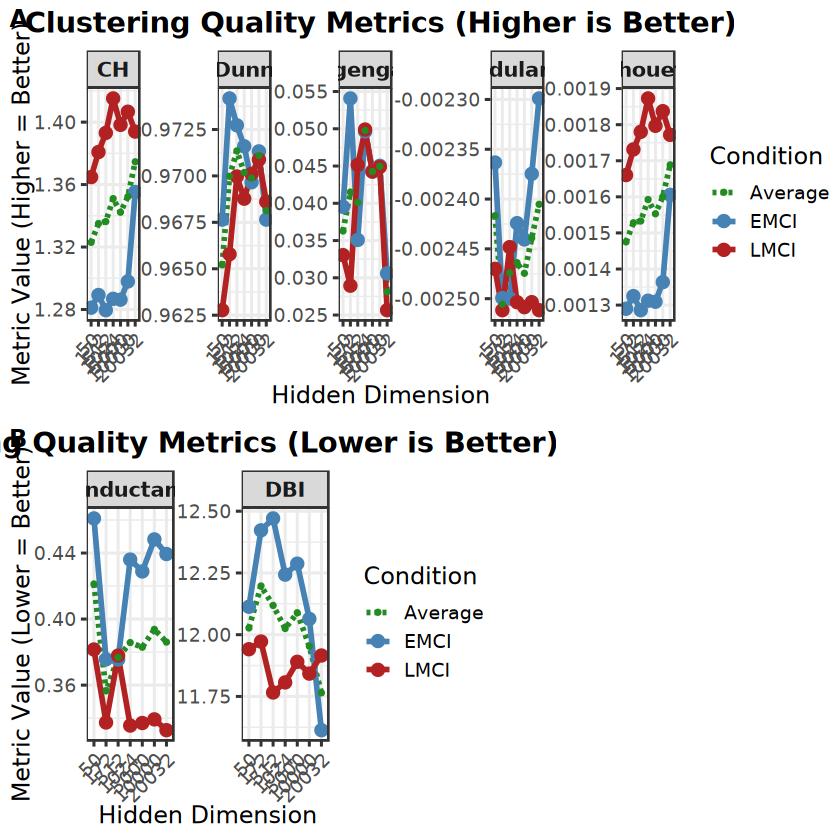

In [11]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(ggpubr)

metrics_emci$Condition <- "EMCI"
metrics_lmci$Condition <- "LMCI"

metrics_all <- rbind(metrics_emci, metrics_lmci)

df_long <- metrics_all %>%
  mutate(Dim = factor(Dim, levels = unique(metrics_all$Dim))) %>%
  pivot_longer(
    cols = c(Modularity, Conductance, CH, DBI, Dunn, Eigengap, Silhouette),
    names_to = "Metric",
    values_to = "Value"
  )

metrics_high_good <- c("Modularity", "CH", "Dunn", "Eigengap", "Silhouette")
metrics_low_good  <- c("Conductance", "DBI")

metrics_mean_long <- metrics_all %>%
  group_by(Dim) %>%
  summarise(
    Modularity  = mean(Modularity,  na.rm = TRUE),
    Conductance = mean(Conductance, na.rm = TRUE),
    CH          = mean(CH,          na.rm = TRUE),
    DBI         = mean(DBI,         na.rm = TRUE),
    Dunn        = mean(Dunn,        na.rm = TRUE),
    Eigengap    = mean(Eigengap,    na.rm = TRUE),
    Silhouette  = mean(Silhouette,  na.rm = TRUE),
    .groups = "drop"
  ) %>%
  pivot_longer(
    cols = c(Modularity, Conductance, CH, DBI, Dunn, Eigengap, Silhouette),
    names_to = "Metric",
    values_to = "MeanValue"
  ) %>%
  mutate(Dim = factor(Dim, levels = unique(metrics_all$Dim)))

df_high_good <- df_long %>% filter(Metric %in% metrics_high_good)

metrics_mean_long$Condition = 'Average'
colnames(metrics_mean_long) = c('Dim','Metric','Value','Condition')
metrics_mean_long = metrics_mean_long[,colnames(df_high_good)]

df_high_good_mean <- metrics_mean_long %>% filter(Metric %in% metrics_high_good)
df_low_good_mean  <- metrics_mean_long %>% filter(Metric %in% metrics_low_good)
df_high_good = rbind(df_high_good,df_high_good_mean)

df_low_good  <- df_long %>% filter(Metric %in% metrics_low_good)
df_low_good = rbind(df_low_good,df_low_good_mean)

p_high <- ggplot(df_high_good,
                 aes(x = Dim, y = Value, color = Condition, linetype = Condition, group = Condition)) +
  geom_line(size = 1.2) +
  geom_point(aes(size = Condition)) + scale_size_manual(values = c( EMCI = 3, LMCI = 3, Average = 1 )) +
  facet_wrap(~ Metric, scales = "free_y", ncol = 5) +
  scale_color_manual(values = c(EMCI="steelblue", LMCI="firebrick",Average='forestgreen')) +
  scale_linetype_manual(values = c(EMCI= "solid",LMCI= "solid",Average = "dashed")) +
  labs(
    x = "Hidden Dimension",
    y = "Metric Value (Higher = Better)",
    title = "Clustering Quality Metrics (Higher is Better)"
  ) +
  theme_bw(base_size = 14) +
  theme(
    strip.text = element_text(size = 12, face = "bold"),
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )


p_low <- ggplot(df_low_good,
                aes(x = Dim, y = Value, color = Condition, linetype = Condition, group = Condition)) +
  geom_line(size = 1.2) +
  geom_point(aes(size = Condition)) + scale_size_manual(values = c( EMCI = 3, LMCI = 3, Average = 1 )) +
  facet_wrap(~ Metric, scales = "free_y", ncol = 2) +
  scale_color_manual(values = c(EMCI="steelblue", LMCI="firebrick",Average='forestgreen')) +
  scale_linetype_manual(values = c(EMCI= "solid",LMCI= "solid",Average = "dashed")) +
  labs(
    x = "Hidden Dimension",
    y = "Metric Value (Lower = Better)",
    title = "Clustering Quality Metrics (Lower is Better)"
  ) +
  theme_bw(base_size = 14) +
  theme(
    strip.text = element_text(size = 12, face = "bold"),
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Create a completely empty plot placeholder
empty_plot <- ggplot() + theme_void()

combined_fig <- ggarrange(
  
  # ---- ROW 1: A alone ----
  ggarrange(
    p_high,
    ncol = 1,
    labels = c("A"),
    font.label = list(size = 14, face = "bold")
  ),
  
  # ---- ROW 2: B + empty placeholder ----
  ggarrange(
    p_low, empty_plot,
    ncol = 2,
    widths = c(1, 0.7),   # equal width so B is visually half-width
    labels = c("B", ""), 
    font.label = list(size = 14, face = "bold")
  ),
  
  ncol = 1,  # stack rows
  heights = c(1, 1)  # optional: row 1 taller than row 2
)

combined_fig

In [96]:
png(paste0('combined_fig_goodness metrics',input,'_final.png'),width = 15,height=8,unit='in',res=300)
combined_fig
dev.off()

png 
  2

In [61]:
p_high_dunn <- ggplot(df_high_good[df_high_good$Metric=='Dunn',],
                 aes(x = Dim, y = Value, color = Condition, linetype = Condition, group = Condition)) +
  geom_line(size = 1.2) +
  geom_point(aes(size = Condition)) + scale_size_manual(values = c( EMCI = 3, LMCI = 3, Average = 1 )) +
  #facet_wrap(~ Metric, scales = "free_y", ncol = 5) +
  scale_color_manual(values = c(EMCI="steelblue", LMCI="firebrick",Average='forestgreen')) +
  scale_linetype_manual(values = c(EMCI= "solid",LMCI= "solid",Average = "dashed")) +
  labs(
    x = "Hidden Dimension",
    y = "Metric Value (Higher = Better)",
    title = "Dunn Index"
  ) +
  theme_bw(base_size = 14) +
  theme(
    strip.text = element_text(size = 20, face = "bold"),
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1,size = 20),
    axis.text.y = element_text(size = 20),
    axis.title.x = element_text(size = 24),
    axis.title.y = element_text(size = 24),
    legend.text  = element_text(size = 20),
    legend.title = element_text(size = 20)
  )

p_low_conductance <- ggplot(df_low_good[df_low_good$Metric=='Conductance',],
                aes(x = Dim, y = Value, color = Condition, linetype = Condition, group = Condition)) +
  geom_line(size = 1.2) +
  geom_point(aes(size = Condition)) + scale_size_manual(values = c( EMCI = 3, LMCI = 3, Average = 1 )) +
  #facet_wrap(~ Metric, scales = "free_y", ncol = 2) +
  scale_color_manual(values = c(EMCI="steelblue", LMCI="firebrick",Average='forestgreen')) +
  scale_linetype_manual(values = c(EMCI= "solid",LMCI= "solid",Average = "dashed")) +
  labs(
    x = "Hidden Dimension",
    y = "Metric Value (Lower = Better)",
    title = "Conductance"
  ) +
  theme_bw(base_size = 14) +
  theme(
    strip.text = element_text(size = 20, face = "bold"),
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1,size = 20),
    axis.text.y = element_text(size = 20),
    axis.title.x = element_text(size = 24),
    axis.title.y = element_text(size = 24),
    legend.text  = element_text(size = 20),
    legend.title = element_text(size = 20)
  )

  # 3) Plot with EMCI, LMCI, and green Average like your other plots
plot_ari <- ggplot(
  df_ari_all,
  aes(x = Dim, y = MeanARI,
      color = Condition,
      linetype = Condition,
      group = Condition)
) +
  geom_line(size = 1.2) +
  geom_point(aes(size = Condition)) +
  scale_color_manual(values = c(
    EMCI = "steelblue",
    LMCI = "firebrick",
    Average = "forestgreen"
  )) +
  scale_linetype_manual(values = c(
    EMCI = "solid",
    LMCI = "solid",
    Average = "dashed"
  )) +
  scale_size_manual(values = c(
    EMCI = 3,
    LMCI = 3,
    Average = 1.5
  )) +
  labs(
    x = "Hidden Dimension",
    y = "ARI",
    #title = "Average ARI Across AE Hidden Dimensions\n(SNF Spectral Clustering Stability)"
    title = "Adjusted Rand Index"
  ) +
  theme_bw(base_size = 14) +
  theme(
    panel.grid.major = element_line(color = "grey90"),
    plot.title = element_text(face = "bold", hjust = 0.5),
    axis.text.x = element_text(angle = 45, hjust = 1,size = 20),
    axis.text.y = element_text(size = 20),
    axis.title.x = element_text(size = 24),
    axis.title.y = element_text(size = 24),
    legend.text  = element_text(size = 20),
    legend.title = element_text(size = 20)
  )
  #facet_wrap(~ Method, nrow = 1)



In [64]:
png('Autoencoder_suppfig2_performance_3scores.png',width = 24,height = 9,unit='in',res=300)
ggarrange(
  plot_ari, p_high_dunn,p_low_conductance,
  ncol = 3, nrow = 1,
  font.label = list(size = 20, face = "bold"),
  common.legend = TRUE, legend = "bottom"
)
dev.off()

png 
  2

png 
  2

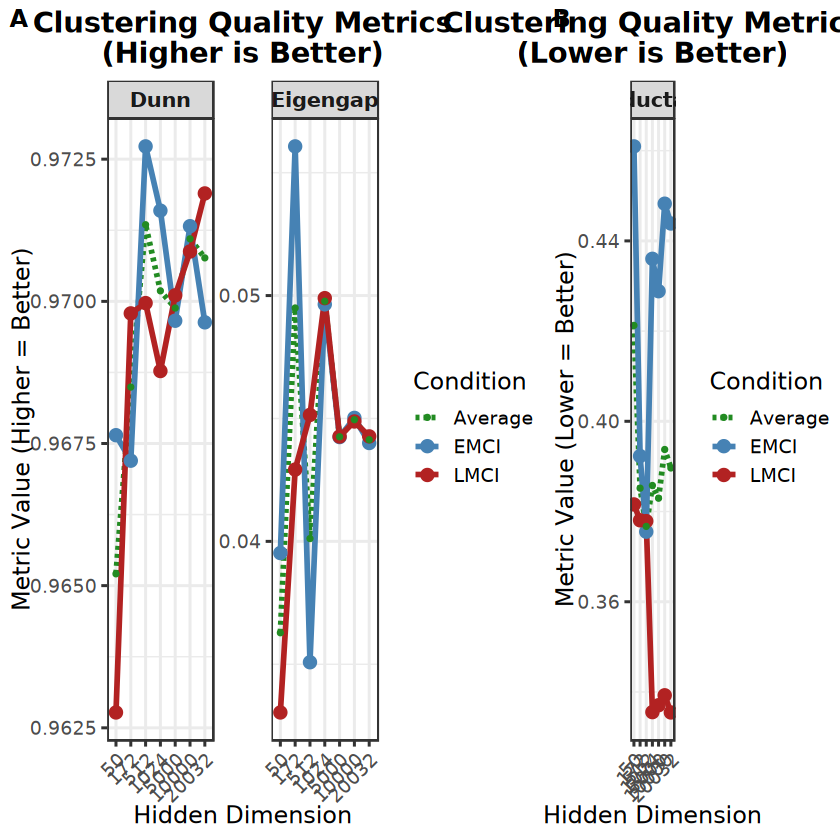

In [97]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(ggpubr)

metrics_emci$Condition <- "EMCI"
metrics_lmci$Condition <- "LMCI"

metrics_all <- rbind(metrics_emci, metrics_lmci)

df_long <- metrics_all %>%
  mutate(Dim = factor(Dim, levels = unique(metrics_all$Dim))) %>%
  pivot_longer(
    cols = c(Modularity, Conductance, CH, DBI, Dunn, Eigengap, Silhouette),
    names_to = "Metric",
    values_to = "Value"
  )

metrics_high_good <- c("Dunn", "Eigengap")
metrics_low_good  <- c("Conductance")

metrics_mean_long <- metrics_all %>%
  group_by(Dim) %>%
  summarise(
    Modularity  = mean(Modularity,  na.rm = TRUE),
    Conductance = mean(Conductance, na.rm = TRUE),
    CH          = mean(CH,          na.rm = TRUE),
    DBI         = mean(DBI,         na.rm = TRUE),
    Dunn        = mean(Dunn,        na.rm = TRUE),
    Eigengap    = mean(Eigengap,    na.rm = TRUE),
    Silhouette  = mean(Silhouette,  na.rm = TRUE),
    .groups = "drop"
  ) %>%
  pivot_longer(
    cols = c(Modularity, Conductance, CH, DBI, Dunn, Eigengap, Silhouette),
    names_to = "Metric",
    values_to = "MeanValue"
  ) %>%
  mutate(Dim = factor(Dim, levels = unique(metrics_all$Dim)))

metrics_mean_long$Condition = 'Average'
colnames(metrics_mean_long) = c('Dim','Metric','Value','Condition')
metrics_mean_long = metrics_mean_long[,colnames(df_high_good)]

df_high_good_mean <- metrics_mean_long %>% filter(Metric %in% metrics_high_good)
df_low_good_mean  <- metrics_mean_long %>% filter(Metric %in% metrics_low_good)

df_high_good <- df_long %>% filter(Metric %in% metrics_high_good)
df_high_good = rbind(df_high_good,df_high_good_mean)

df_low_good  <- df_long %>% filter(Metric %in% metrics_low_good)
df_low_good = rbind(df_low_good,df_low_good_mean)

p_high <- ggplot(df_high_good,
                 aes(x = Dim, y = Value, color = Condition, linetype = Condition, group = Condition)) +
  geom_line(size = 1.2) +
  geom_point(aes(size = Condition)) + scale_size_manual(values = c( EMCI = 3, LMCI = 3, Average = 1 )) +
  facet_wrap(~ Metric, scales = "free_y", ncol = 5) +
  scale_color_manual(values = c(EMCI="steelblue", LMCI="firebrick",Average='forestgreen')) +
  scale_linetype_manual(values = c(EMCI= "solid",LMCI= "solid",Average = "dashed")) +
  labs(
    x = "Hidden Dimension",
    y = "Metric Value (Higher = Better)",
    title = "Clustering Quality Metrics\n(Higher is Better)"
  ) +
  theme_bw(base_size = 14) +
  theme(
    strip.text = element_text(size = 12, face = "bold"),
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )


p_low <- ggplot(df_low_good,
                aes(x = Dim, y = Value, color = Condition, linetype = Condition, group = Condition)) +
  geom_line(size = 1.2) +
  geom_point(aes(size = Condition)) + scale_size_manual(values = c( EMCI = 3, LMCI = 3, Average = 1 )) +
  facet_wrap(~ Metric, scales = "free_y", ncol = 2) +
  scale_color_manual(values = c(EMCI="steelblue", LMCI="firebrick",Average='forestgreen')) +
  scale_linetype_manual(values = c(EMCI= "solid",LMCI= "solid",Average = "dashed")) +
  labs(
    x = "Hidden Dimension",
    y = "Metric Value (Lower = Better)",
    title = "Clustering Quality Metrics\n(Lower is Better)"
  ) +
  theme_bw(base_size = 14) +
  theme(
    strip.text = element_text(size = 12, face = "bold"),
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Create a completely empty plot placeholder
empty_plot <- ggplot() + theme_void()

ggarrange(
  p_high, p_low,
  ncol = 2, nrow = 1,
  widths = c(2.2,1.2),
  labels = c("A", "B"),
  font.label = list(size = 14, face = "bold")
)

png(paste0('combined_fig_goodness_top3_',input,'_final.png'),width = 15,height=6,unit='in',res=300)
ggarrange(
  p_high, p_low,
  ncol = 2, nrow = 1,
  widths = c(2.2,1.2),
  labels = c("A", "B"),
  font.label = list(size = 14, face = "bold")
)
dev.off()
